In [2]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape
from keras.callbacks import CSVLogger
import tensorflow as tf
#from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import GRU, CuDNNGRU
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py

In [3]:
with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]


In [5]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [8]:
ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
print (ground_true_times.shape)
print (ground_true.shape)

(301, 272, 1)
(301, 272, 1)


In [9]:
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]
epochs = 1
output_size=16
units= 50

In [12]:
model = Sequential()
model.add(GRU(units=units, activation=None, input_shape=(step_size,nb_features),return_sequences=False))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(Activation('relu'))
model.load_weights('weights/bitcoin2015to2017_close_GRU_1_tanh_relu_-01-0.00015.hdf5')
model.compile(loss='mse', optimizer='adam')

In [13]:
original_datas.shape

(409577, 1)

In [15]:
predicted = model.predict(validation_datas)
predicted_inverted = []

# In[7]:
# we only care about the 0 axis, close price data

scaler.fit(original_datas[:,0].reshape(-1,1))
predicted_inverted.append(scaler.inverse_transform(predicted))
print (np.array(predicted_inverted).shape)
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print (np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(1, 301, 16)
(4816,)


In [16]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df.set_index('times').reset_index()
ground_true_df.shape

(81872, 2)

In [17]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
prediction_df.shape

(4816, 2)

In [21]:
prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2018 )&(prediction_df["times"].dt.month > 7 ),: ]
ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2018 )&(ground_true_df["times"].dt.month > 7 ),:]

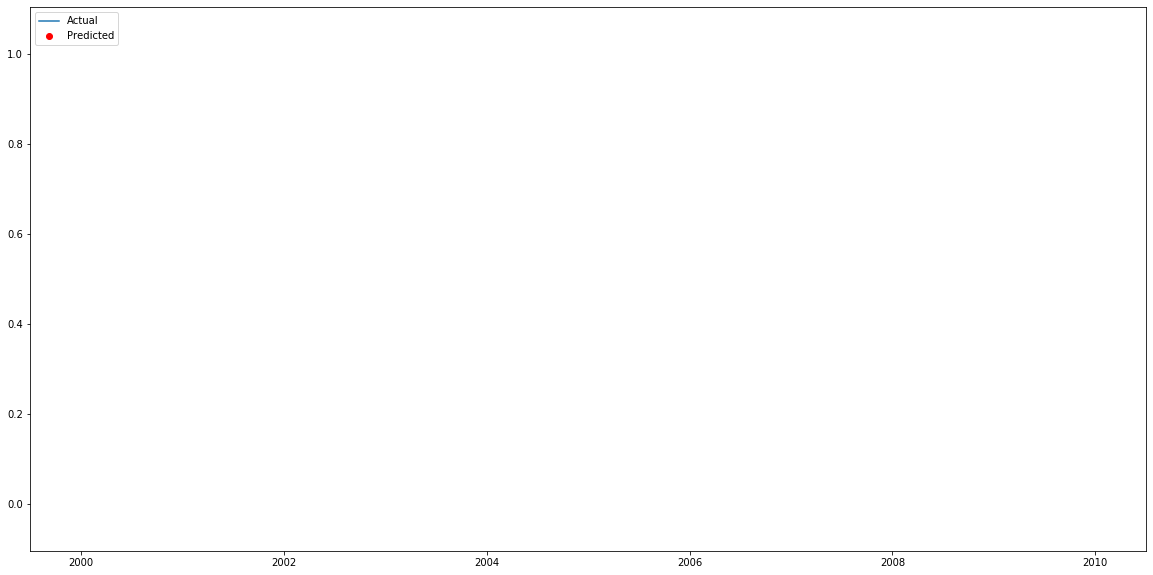

In [22]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.savefig('result/bitcoin2015to2017_close_GRU_1_tanh_relu_result.png')
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_original_outputs[:,:,0].reshape(-1),predicted_inverted)

93453.90067019087